# Clustering

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# new import statements
from sklearn.cluster import KMeans, AgglomerativeClustering

# Unsupervised Machine Learning: Clustering

- In classification (supervised), we try to find boundaries/rules to separate points according to pre-determined labels.
- In clustering, the algorithm chooses the labels.  Goal is to choose labels so that similar rows get labeled the same.

### K-Means Clustering

- K: number of clusters:
    - 3-Means => 3 clusters
    - 4-Means => 4 clusters, and so on
- Means: we will find centroids (aka means aka averages) to create clusters

- import statement:
```python
from sklearn.cluster import KMeans
```

#### Iterative algorithm for K-Means

In [2]:
# Generate random data
x, y = datasets.make_blobs(n_samples=100, centers=3, cluster_std=1.2, random_state=3)
df = pd.DataFrame(x, columns=["x0", "x1"])
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


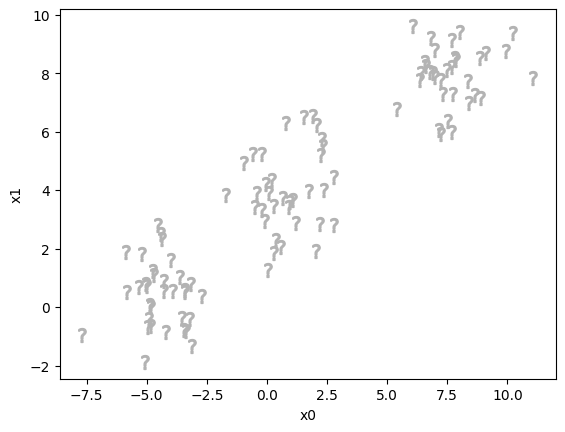

In [3]:
def km_scatter(df, **kwargs):
    """
    Produces scatter plot visualizations with x0 on x-axis and y0 on y-axis.
    It can also plot the centroids for clusters.
    Parameters:
        x0 => x-axis
        x1 => y-axis
        cluster => marker type
    """
    ax = kwargs.pop("ax", None)
    if not "label" in df.columns:
        return df.plot.scatter(x="x0", y="x1", marker="$?$", ax=ax, **kwargs)

    for marker in set(df["label"]):
        sub_df = df[df["label"] == marker]
        ax = sub_df.plot.scatter(x="x0", y="x1", marker=marker, ax=ax, **kwargs)
    return ax

ax = km_scatter(df, s=100, c="0.7")

### Hard Problem

Finding the best answer. What is the answer? Determing the centroids of the clusters.

### Easier Problem

Taking a random answer and make it a little better. Then repeat!
Downside? If randomization leads to very bad initial choice of centroids, that might lead to bad clustering (fewer clusters).

<Axes: xlabel='x0', ylabel='x1'>

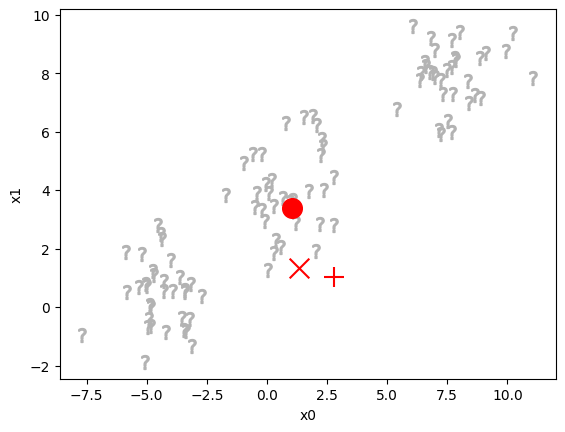

In [4]:
clusters = np.random.uniform(-5, 5, size=(3, 2))
clusters = pd.DataFrame(clusters, columns=["x0", "x1"])
clusters["label"] = ["o", "+", "x"]

ax = km_scatter(df, s=100, c="0.7")
km_scatter(clusters, s=200, c="red", ax=ax)

Two variables for us to deal with:
1. clusters: contains location of centroids and a label for them
2. df: contains the actual data points

In [5]:
clusters

,x0,x1,label
0,1.061669,3.385615,o
1,2.771363,1.039187,+
2,1.329270,1.331542,x


In [6]:
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


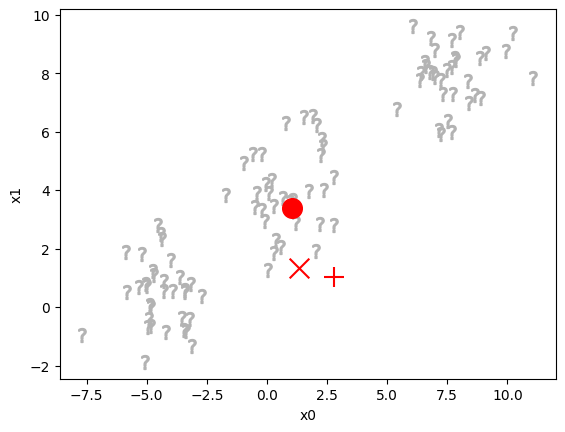

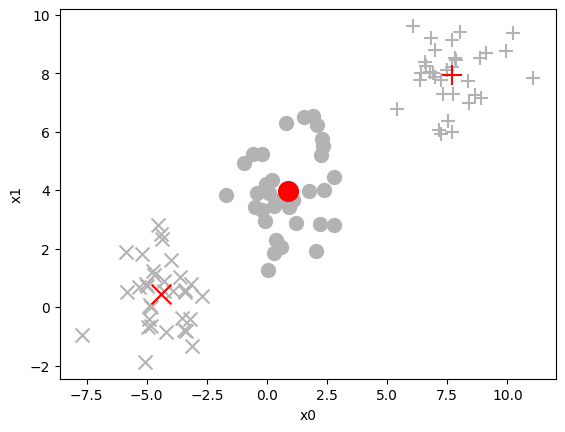

In [7]:
class KM:
    def __init__(self, df, clusters):
        # We make copies because we are going to keep changing the dataframe to 
        # identify better clusters
        self.df = df.copy()
        self.clusters = clusters.copy()
        self.labels = clusters["label"].values
        
    def plot(self):
        ax = km_scatter(self.df, color="0.7", s=100)
        km_scatter(self.clusters, ax=ax, color="red", s=200)
        
    def assign_points(self):
        """
        compute Euclidean distance between each point and each centroids
        """
        for center in self.clusters.itertuples():
            # Euclidean distance
            x0_diff = df["x0"] - center.x0
            x1_diff = df["x1"] - center.x1
            distances = (x0_diff ** 2 + x1_diff ** 2) ** 0.5
            # add distance to each centroid as a column within the dataframe
            self.df[center.label] = distances
        # get the label of the nearest centroid
        self.df["label"] = self.labels[self.df[self.labels].values.argmin(axis=1)]
    
    def update_centers(self):
        """
        update centroids by taking mean of the points that are nearest to that
        particular centroid
        """
        for center in self.clusters.itertuples():
            subset_df = self.df[self.df["label"] == center.label]
            if len(subset_df) > 0:
                x0 = subset_df["x0"].mean()
                x1 = subset_df["x1"].mean()
                self.clusters.at[center.Index, "x0"] = x0
                self.clusters.at[center.Index, "x1"] = x1

"""
High-level algorithm:
1. Start with random locations for centroids
2. Iterate over each data point:
    1. Find the distance (Euclidean distance) between current data point and each centroid.
    2. Find the minimum of those distances and the corresponding label.
    3. Assign current data point to the closest cluster centroid label.
4. Once all points are assigned, compute new centroid for each cluster. Iterate over 
   each cluster:
    1. Extract subset of data points which got assigned to curr cluster label.
    2. Compute mean of all the assigned data points.
    3. Update cluster centroid.
5. Repeat steps 2 to 4 many times (iterative improvement).
"""

# Creating object instance
km = KM(df, clusters)
km.plot()

# km.assign_points()
# km.plot()
# km.update_centers()

for i in range(10):
    km.assign_points()
    km.update_centers()
    
km.plot()

### `sklearn KMeans`

- import statement:
```python
from sklearn.cluster import KMeans
```
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

**Instantiation:**
`KMeans(n_clusters=<num>, n_init=<num>, max_iter=<num>)`
- `n_clusters`: number of clusters to be formed
- `n_init`: number of initial random seeds to try (to avoid downside of bad initial random choices)
- `max_iter`: maximum number of iterations for a single K-means run (single starting seed)

In [8]:
km_cluster = KMeans(3)
km_cluster

KMeans(n_clusters=3)

In [9]:
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


**Methods:**
1. `fit`: find good centroids
2. `transform`: give me the distances from each point to each centroid
3. `predict`: give me the chosen group labels

**Attributes:**
- `<km object>.cluster_centers_`: coordinates of cluster centers
- `<km object>.inertia_`: sum of squared distances of samples to their closest cluster center

In [10]:
# `fit`: find good centroids
km_cluster.fit(df)
# coordinates of cluster centers
km_cluster.cluster_centers_

array([[-4.41347291,  0.43410278],
       [ 7.69751168,  7.9241129 ],
       [ 0.85985598,  3.98556415]])

**Observeration:** 3 rows (because we have 3 clusters), and 2 columns (because the df had 2 columns).

In [11]:
# `transform`: give me the distances from each point to each centroid
km_cluster.transform(df)

array([[14.72748598,  0.69550479,  8.39955315],
       [ 1.71217188, 12.83849367,  5.057144  ],
       [ 1.47333179, 13.72080475,  5.984516  ],
       [ 2.18458064, 14.24916908,  6.65257594],
       [12.86625407,  1.93249405,  6.62911793],
       [ 1.56004975, 14.14472291,  6.42867089],
       [ 1.29983259, 14.79157898,  7.00663718],
       [13.35025948,  1.56332001,  7.09747529],
       [ 1.20010768, 13.93648735,  6.1620119 ],
       [ 5.12923462,  9.23940355,  1.75079801],
       [ 1.23053441, 15.29849451,  7.45185474],
       [15.3322184 ,  1.52459286,  8.98045036],
       [17.16390523,  3.37380113, 10.91386222],
       [14.40658807,  0.29966036,  8.05146158],
       [ 7.66113117,  6.61820665,  1.50499677],
       [ 2.37571603, 13.2665394 ,  5.52922108],
       [14.65282383,  0.53707918,  8.29635389],
       [14.25952349,  1.55598141,  7.93015965],
       [ 1.90656095, 13.29440299,  5.48003982],
       [ 0.96395695, 15.0936722 ,  7.2343239 ],
       [ 4.992096  ,  9.25115661,  1.418

**Observations**: Each row corresponds to a row in df. 3 columns correspond to 3 distances to the centroids.

In [12]:
# `predict`: give me the chosen group labels
km_cluster.predict(df)

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 0, 0, 2, 2,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2,
       0, 0, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2,
       1, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 0, 1,
       2, 1, 2, 1, 1, 0, 1, 0, 0, 2, 1, 1], dtype=int32)

### How many clusters do we need?

- metric: `<km object>.inertia_`: sum of squared distances of samples to their closest cluster center

In [13]:
km_cluster.inertia_

260.7196850565891

**Observation**: we want "inertia" to be as small as possible.

### Elbow plot to determine `n_clusters`

In [14]:
# create a series with clusters 1 to 10 and corresponding values are equal to intertia 
s = pd.Series(dtype=float)

for num_clusters in range(1, 11):
    km = KMeans(num_clusters)
    km.fit(df)
    s.at[num_clusters] = km.inertia_

s

1     3621.095890
2      927.007644
3      260.719685
4      233.248301
5      191.945884
6      156.733243
7      133.903932
8      119.617138
9      106.558297
10      83.057488
dtype: float64

Text(0.5, 0, 'Number of clusters')

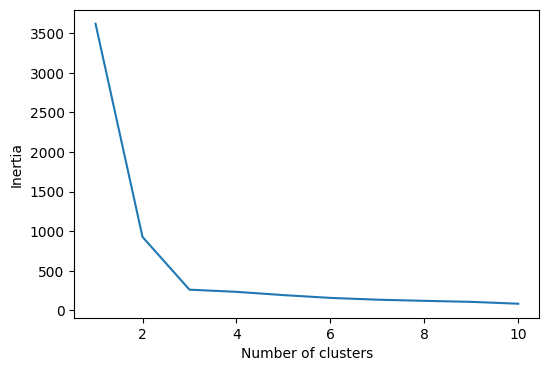

In [15]:
ax = s.plot.line(figsize=(6, 4))
ax.set_ylabel("Inertia")
ax.set_xlabel("Number of clusters")

**Observation**: there is an "elbow" around `n_clusters`=3.

#### Will we always have a clear "elbow"?

- Let's generate uniform random data

Text(0.5, 0, 'Number of clusters')

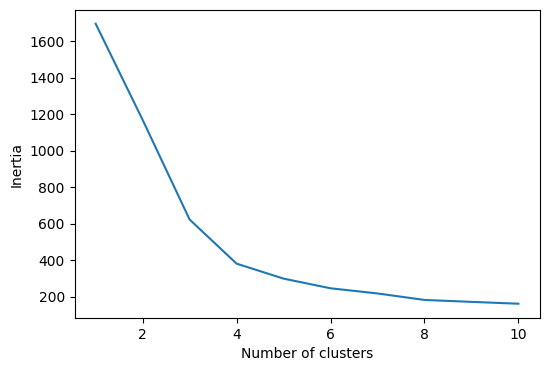

In [16]:
df2 = pd.DataFrame(np.random.uniform(0, 10, (100, 2)))

s = pd.Series(dtype=float)

for num_clusters in range(1, 11):
    km = KMeans(num_clusters)
    km.fit(df2)
    s.at[num_clusters] = km.inertia_

ax = s.plot.line(figsize=(6, 4))
ax.set_ylabel("Inertia")
ax.set_xlabel("Number of clusters")

**Observation**: there is an "elbow" around `n_clusters`=3.

#### Will we always have a clear "elbow"?

- Let's generate uniform random data

<Axes: xlabel='0', ylabel='1'>

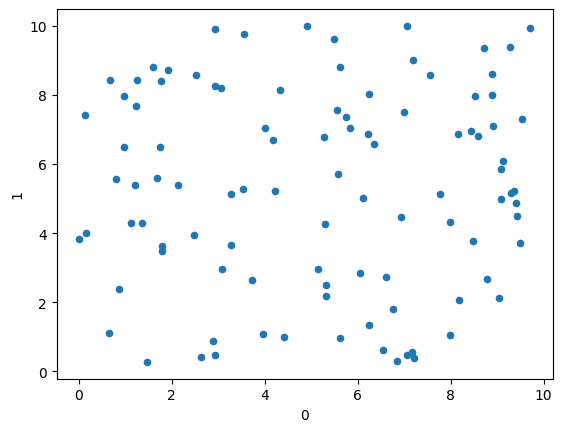

In [17]:
df2 = pd.DataFrame(np.random.uniform(0, 10, (100, 2)))
df2.plot.scatter(0, 1)

Text(0.5, 0, 'Number of clusters')

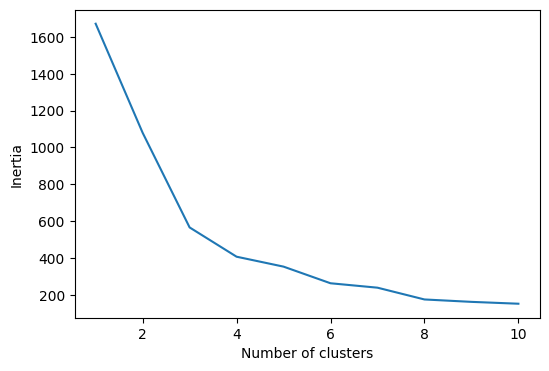

In [18]:
s = pd.Series(dtype=float)

for num_clusters in range(1, 11):
    km = KMeans(num_clusters)
    km.fit(df2)
    s.at[num_clusters] = km.inertia_

ax = s.plot.line(figsize=(6, 4))
ax.set_ylabel("Inertia")
ax.set_xlabel("Number of clusters")

### K-Means use cases:

1. estimator
2. transformer:
    - sometimes we'll use an unsupervised learning technique (like k-means) to pre-process data, creating better inputs for a supervised learning technique (like logistic regression)

In [19]:
def make_data():
    x, y = datasets.make_blobs(n_samples=250, centers=5, random_state=5)
    xcols = ["x0", "x1"]
    df1 = pd.DataFrame(x, columns=xcols)
    df1["y"] = y > 0

    df2 = pd.DataFrame(np.random.uniform(-10, 10, size=(250, 2)), columns=["x0", "x1"])
    df2["y"] = False

    return pd.concat((df1, df2))

train, test = train_test_split(make_data())

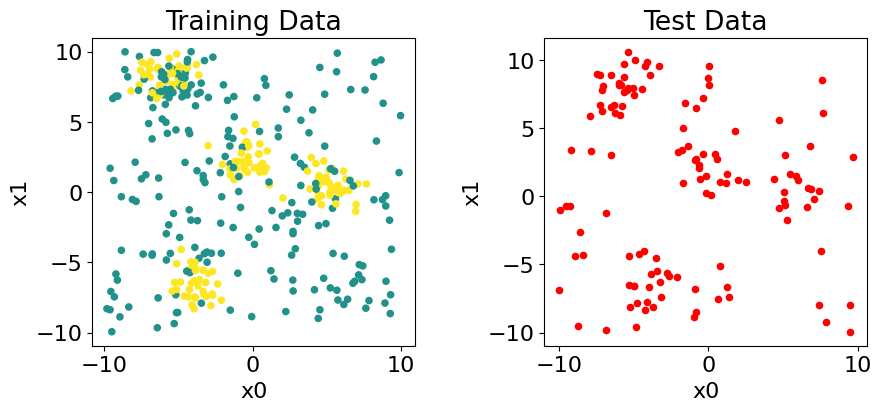

In [20]:
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
train.plot.scatter(x="x0", y="x1", c=train["y"], vmin=-1, ax=ax[0])
test.plot.scatter(x="x0", y="x1", c="red", ax=ax[1])
ax[0].set_title("Training Data")
ax[1].set_title("Test Data")
plt.subplots_adjust(wspace=0.4)

#### Objective: use `LogisticRegression` to classify points as "black" or "gray".

In [21]:
model = Pipeline([
    ("km", KMeans(10)),
    ("lr", LogisticRegression()),
])
model.fit(train[["x0", "x1"]], train["y"])
model.score(test[["x0", "x1"]], test["y"])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.768

In [22]:
model = Pipeline([
    ("km", KMeans(10)),
    ("std", StandardScaler()),
    ("lr", LogisticRegression()),
])
model.fit(train[["x0", "x1"]], train["y"])
model.score(test[["x0", "x1"]], test["y"])

0.784

### `StandardScaler` with `KMeans`

Recall that `StandardScaler` should always be applied after applying `PolynomialFeatures` (from last lecture).

<Axes: xlabel='0', ylabel='1'>

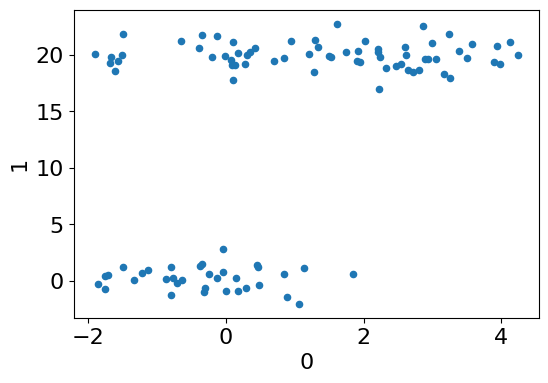

In [23]:
x = datasets.make_blobs(centers=np.array([(0, 0), (0, 20), (3, 20)]))[0]
df = pd.DataFrame(x)
df.plot.scatter(x=0, y=1, figsize=(6, 4))

In [24]:
km_c = KMeans(2)
km_c.fit(df)
km_c.predict(df)

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1], dtype=int32)

#### `fit_predict(...)` is a shortcut for `fit` and `predict` method invocations.

In [25]:
KMeans(2).fit_predict(df)

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

<Axes: xlabel='0', ylabel='1'>

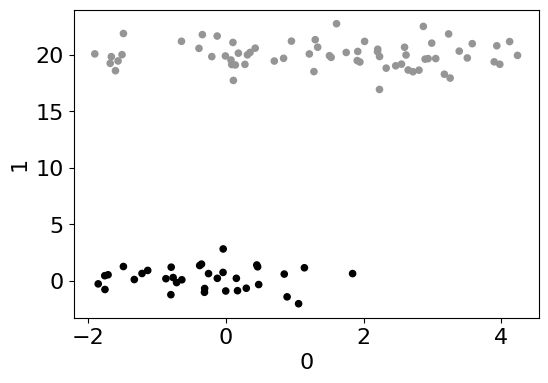

In [26]:
# -1 => white, 0 => gray, 1 => black
df.plot.scatter(x=0, y=1, figsize=(6, 4), c=KMeans(2).fit_predict(df), vmin=-1, vmax=1)

**Observation**: scale for columns are intentionally not specified.

In [27]:
df

,0,1
0,0.100545,21.103113
1,-1.905560,20.090298
2,0.845871,0.601467
3,0.135428,19.112968
4,3.932600,20.812123
...,...,...
95,2.228549,16.943121
96,-0.800577,-1.224476
97,-0.641707,0.094791
98,0.458996,1.245383


Let's make a copy of the data. Assuming initial data for both columns is in "km", let's convert one column (`0`) into "meters". 

In [28]:
df2 = df.copy()
df2[0] *= 1000 # km => m
df2.head()

,0,1
0,100.545395,21.103113
1,-1905.559750,20.090298
2,845.871256,0.601467
3,135.427694,19.112968
4,3932.599835,20.812123


<Axes: xlabel='0', ylabel='1'>

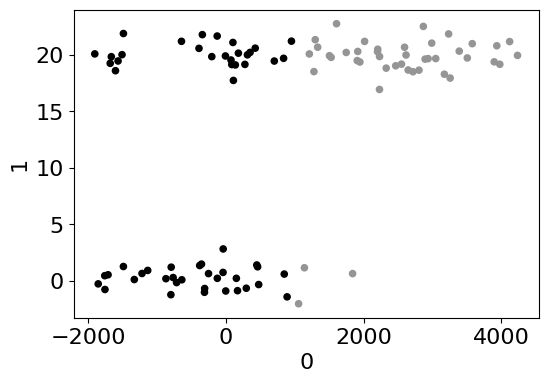

In [29]:
df2.plot.scatter(x=0, y=1, figsize=(6,4), c=KMeans(2).fit_predict(df2), vmin=-1, vmax=1)

**Observations**:
- One would expect to see the same clusters, but that is not happening here. Why?
    - x-axis difference is too high when compared to the y-axis difference
    - That is, KMeans doesn't get that x-axis has scaled data, whereas y-axis doesn't have scaled data
- This is not too far off from realistic datasets. 
    - That is, real-world dataset columns might have difference units. 
    - For example, one column might be representing temperature data where as another might be representing distance.

#### Conclusion: `StandardScaler` should be applied before `KMeans`

<Axes: xlabel='0', ylabel='1'>

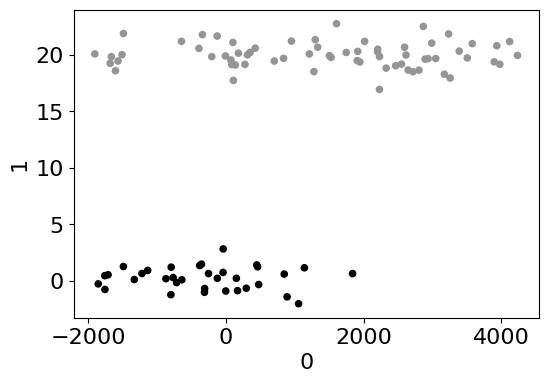

In [30]:
model = Pipeline([
    ("std", StandardScaler()),
    ("km", KMeans(2)),
])

df2.plot.scatter(x=0, y=1, figsize=(6, 4), c=model.fit_predict(df2), vmin=-1, vmax=1)

### Wisconsin counties example

In [31]:
df = gpd.read_file("counties.geojson")
df.head()

,NAME,POP100,AREALAND,HU100,developed,forest,pasture,crops,geometry
0,Racine County,195408,861533739,82164,0.230906,0.100167,0.072588,0.482126,"POLYGON ((645313.81834 2212738.58489, 645456.3..."
1,Clark County,34690,3133378070,15076,0.046476,0.326691,0.022979,0.444642,"POLYGON ((431909.29098 2393751.35940, 433872.5..."
2,Wood County,74749,2054044751,34088,0.080285,0.226244,0.023411,0.320990,"POLYGON ((498653.94690 2388370.84202, 498647.3..."
3,Rusk County,14755,2366092584,8883,0.035567,0.473937,0.049572,0.138357,"POLYGON ((397166.23292 2498521.78567, 397167.7..."
4,Ozaukee County,86395,603514413,36267,0.222642,0.088609,0.127867,0.389109,"POLYGON ((654796.85595 2272096.94081, 654799.8..."


#### If we want to use "POP100", "AREALAND", "developed", "forest", "pasture", "crops" for clustering, what transformer should we use? 

- StandardScaler.

### Goal here: cluster counties based on similar land usage.

<Axes: >

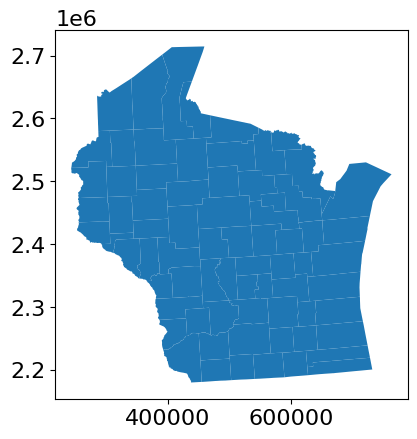

In [32]:
df.plot()

<Axes: >

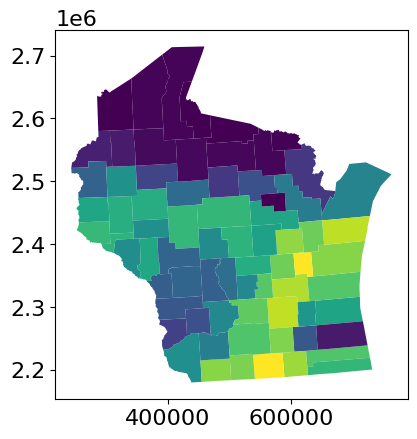

In [33]:
df.plot(column="crops")

<Axes: >

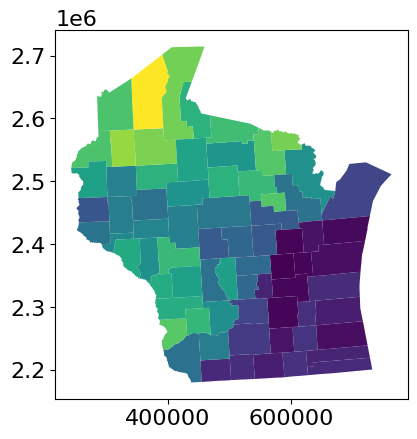

In [34]:
df.plot(column="forest")

### KMeans

1.290908515122804
[3 1 1 2 3 1 3 0 2 1 3 3 3 2 1 0 1 1 2 2 1 2 1 3 1 1 1 1 2 3 3 3 2 1 1 1 3
 1 2 3 3 1 1 3 2 2 2 3 1 1 1 3 2 2 2 3 1 1 3 3 2 3 2 2 3 1 2 2 1 2 2 1]


<Axes: >

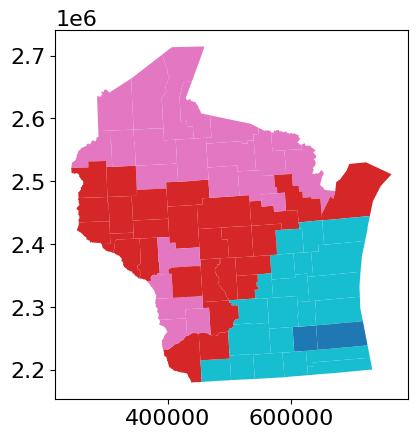

In [35]:
xcols = ["developed", "forest", "pasture", "crops"]

# instantiate
km_c = KMeans(4)
# fit
km_c.fit(df[xcols])
# predict
clusters = km_c.predict(df[xcols])

print(km_c.inertia_)
print(clusters)

df.plot(column=clusters, cmap="tab10")

**Observation**: cluster number can be random. That is, if you re-run the above cell twice, you will get different number for each cluster.

### Agglomerative clustering

- import statement
```python
from sklearn.cluster import AgglomerativeClustering
```

In [36]:
xcols = ["developed", "forest", "pasture", "crops"]

# instantiate
km_c = AgglomerativeClustering(4)
# fit
km_c.fit(df[xcols])
# predict
clusters = km_c.predict(df[xcols])

print(km_c.inertia_)
print(clusters)

df.plot(column=clusters, cmap="tab10")

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

**Observations**: 
- no centroids => no inertia => no elbow plots (how do we pick cluster count?):
    - AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'
- no `predict` method, but there is `fit_predict`:
    - AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'
    - why?
        - because each point could lead to a completely different tree
        - remember unlike KMeans (which is top-down), AgglomerativeClustering is bottom-up

[2 1 1 0 2 0 2 3 0 1 2 2 2 0 1 3 1 1 0 0 1 0 0 2 0 1 1 1 0 2 2 2 0 1 1 1 2
 1 0 2 2 1 1 2 0 0 0 2 1 1 1 2 0 0 0 2 1 1 2 2 0 2 0 0 2 0 0 0 0 0 0 1]


<Axes: >

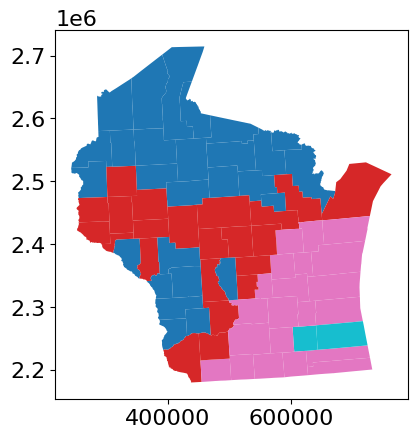

In [37]:
xcols = ["developed", "forest", "pasture", "crops"]

# instantiate
km_c = AgglomerativeClustering(4)
# fit_predict
clusters = km_c.fit_predict(df[xcols])

# print(km_c.inertia_)
print(clusters)

df.plot(column=clusters, cmap="tab10")